DSCI 100 008 Project
Group 8

In [1]:
#Loading Packages
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)

set.seed(999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
ff_raw <- read_csv("https://raw.githubusercontent.com/MingTxm/DSCI100_GroupProject/main/forestfires.csv")
head(ff_raw)

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


In [34]:
# Filtering unnecessary data
ff <- ff_raw |>
    select(month, ISI, FFMC, RH, temp, wind) |>
    arrange(desc(month)) |>
    drop_na()
head(ff)
nrow(ff)

# Splitting the Data
ff_split <- initial_split(ff, prop = 0.75, strata = ISI)
    ff_train <- training(ff_split)
    ff_test <- testing(ff_split)

month,ISI,FFMC,RH,temp,wind
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sep,7.0,91.0,63,13.1,5.4
sep,7.1,92.5,40,22.8,4.0
sep,7.1,92.5,51,17.8,7.2
sep,22.6,92.8,38,19.3,4.0
sep,7.0,90.9,42,21.3,2.2
sep,9.2,92.9,21,26.4,4.5


[1] 517

In [11]:
# Getting a row count & mean values
ff_count <- ff_train |>
    group_by(month)|>
    summarize(count = n())

ff_mean <- ff_train |>
    group_by(month) |>
    summarize(mean(ISI), mean(RH), mean(FFMC), mean(temp), mean(wind))
    
ff_summary <- bind_cols(ff_count, ff_mean) |>
    select(-month...3) |>
    rename(month = month...1)

ff_summary

New names:
• `month` -> `month...1`
• `month` -> `month...3`


month,count,mean(ISI),mean(RH),mean(FFMC),mean(temp),mean(wind)
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
apr,8,5.712500,46.00000,86.32500,12.825000,4.525000
aug,134,10.916418,46.60448,92.09104,21.336567,4.050746
dec,7,3.800000,37.71429,84.95714,4.428571,7.914286
feb,11,3.554545,55.18182,83.26364,10.681818,2.963636
jan,1,2.900000,78.00000,82.10000,5.300000,3.100000
jul,26,9.692308,46.19231,91.71154,21.719231,3.892308
jun,11,13.072727,43.45455,88.36364,20.272727,3.990909
mar,42,7.140476,40.64286,89.26429,13.083333,4.897619
may,2,4.600000,67.00000,87.35000,14.650000,4.450000


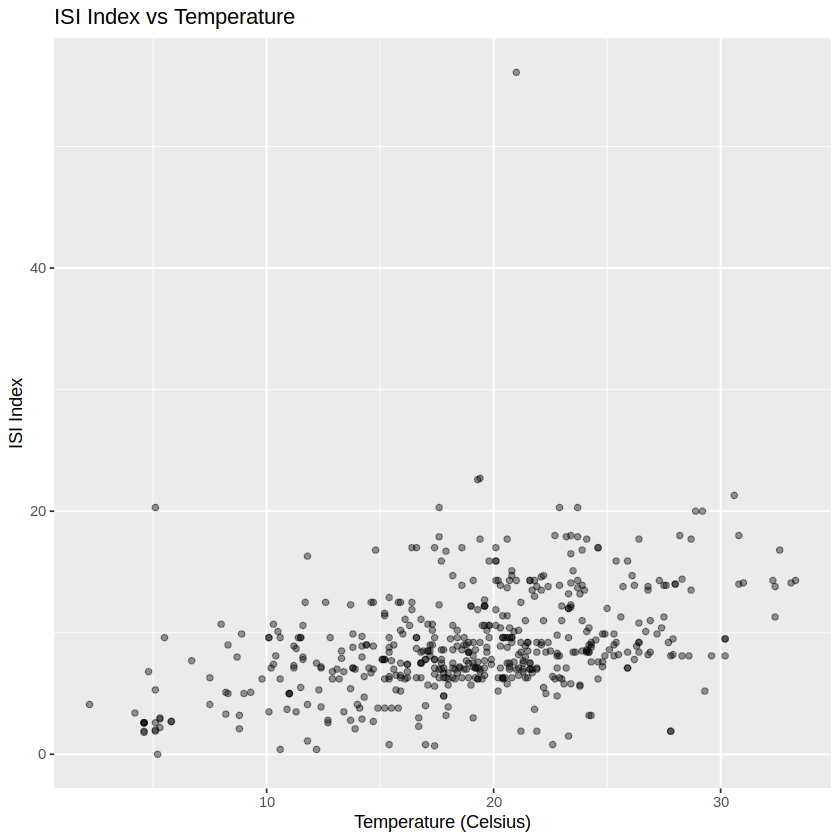

In [18]:
# ISI vs Temperature Plot #
ff_temp_plot <- ff |>
    ggplot(aes(x = temp, y = ISI)) +
        geom_point(alpha = 0.4) +
        labs(x = "Temperature (Celsius)", y = "ISI Index", title = "ISI Index vs Temperature")
ff_temp_plot

In [32]:
# Linear Regression Model #

ff_train_temp <- ff_train |>
    select(ISI, temp)
head(ff_train_temp)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_temp_recipe <- recipe(ISI ~ temp, data = ff_train_temp)

lm_fit <- workflow()|>
    add_recipe(lm_temp_recipe) |>
    add_model(lm_spec) |>
    fit(data = ff_train_temp)

ISI,temp
<dbl>,<dbl>
5.8,20.6
6.3,18.2
6.2,12.9
6.3,17.8
4.8,17.8
4.8,22.8


.pred,month,ISI,temp
<dbl>,<chr>,<dbl>,<dbl>
7.382943,sep,7.0,13.1
10.174782,sep,7.1,22.8
9.167417,sep,22.6,19.3
12.304638,sep,8.1,30.2
8.706908,sep,7.8,17.7
9.599145,sep,9.2,20.8


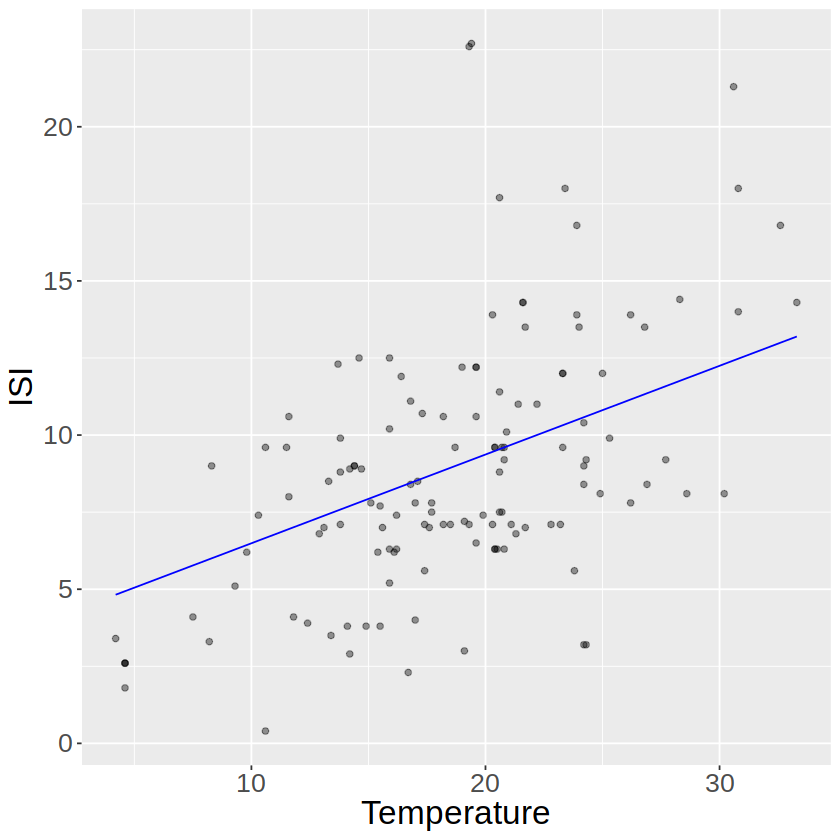

In [33]:
## Making the Prediction ##

lm_wind_prediction <- lm_fit |>
    predict(ff_test) |>
    bind_cols(ff_test) |>
    select(.pred, month, ISI, temp)
head(lm_wind_prediction)

## Plotting the Prediction ##

lm_wind_prediction_plot <- lm_wind_prediction |>
    ggplot(aes(x = temp, y = ISI)) +
        geom_point(alpha = 0.4) +
        geom_line(mapping = aes(x = temp, y = .pred), color = "blue") +
        xlab("Temperature") +
        ylab("ISI") +
        theme(text = element_text(size = 20))
lm_wind_prediction_plot